In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import itertools
from pylab import rcParams
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('PJMW_MW_Hourly.xlsx',header=0,parse_dates=True)
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077
1,2002-12-31 02:00:00,4939
2,2002-12-31 03:00:00,4885
3,2002-12-31 04:00:00,4857
4,2002-12-31 05:00:00,4930


In [3]:
df.set_index('Datetime', inplace=True)

In [4]:
#Finding outliers

def find_outliers_IQR(df):
    
    Q1 = df.quantile(0.25)

    Q3 = df.quantile(0.75)
    
    IQR = Q3 - Q1
    
    outliers= df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return outliers

outliers = find_outliers_IQR(df['PJMW_MW'])

In [5]:
#Define the percentile limits for winsorization 

pct_lower = 0.01
pct_upper = 0.95

df['PJMW_MW'] = np.clip(df['PJMW_MW'],
                df['PJMW_MW'].quantile(pct_lower),
                df['PJMW_MW'].quantile(pct_upper))

In [6]:
df['PJMW_MW']

Datetime
2002-12-31 01:00:00    5077.0
2002-12-31 02:00:00    4939.0
2002-12-31 03:00:00    4885.0
2002-12-31 04:00:00    4857.0
2002-12-31 05:00:00    4930.0
                        ...  
2018-01-01 20:00:00    7330.0
2018-01-01 21:00:00    7330.0
2018-01-01 22:00:00    7330.0
2018-01-01 23:00:00    7330.0
2018-01-02 00:00:00    7330.0
Name: PJMW_MW, Length: 143206, dtype: float64

In [7]:
df['date']=df.index
df['hour']=df['date'].dt.hour
df["month"] = df.index.month
df["day"] = df['date'].dt.strftime("%d")
df['Day'] = df['day'].astype(str).astype(int)
df['year']=df['date'].dt.year
df.drop(['date','day'], axis = 1, inplace=True)

In [8]:
df.dtypes

PJMW_MW    float64
hour         int64
month        int64
Day          int32
year         int64
dtype: object

In [9]:
df.head()

,PJMW_MW,hour,month,Day,year
Datetime,,,,,
2002-12-31 01:00:00,5077.0,1,12,31,2002
2002-12-31 02:00:00,4939.0,2,12,31,2002
2002-12-31 03:00:00,4885.0,3,12,31,2002
2002-12-31 04:00:00,4857.0,4,12,31,2002
2002-12-31 05:00:00,4930.0,5,12,31,2002


In [10]:
#Train-Test split

train=df.loc[df.year < 2018]
test = df.loc[df.year >= 2018]

In [11]:
xtrain = train[['hour','month','year','Day']]
xtest = test[['hour','month','year','Day']]
ytrain = train[['PJMW_MW']]
ytest = test[['PJMW_MW']]

In [12]:
xtrain

,hour,month,year,Day
Datetime,,,,
2002-12-31 01:00:00,1,12,2002,31
2002-12-31 02:00:00,2,12,2002,31
2002-12-31 03:00:00,3,12,2002,31
2002-12-31 04:00:00,4,12,2002,31
2002-12-31 05:00:00,5,12,2002,31
...,...,...,...,...
2017-01-01 20:00:00,20,1,2017,1
2017-01-01 21:00:00,21,1,2017,1
2017-01-01 22:00:00,22,1,2017,1


In [13]:
ytrain

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0
...,...
2017-01-01 20:00:00,5690.0
2017-01-01 21:00:00,5668.0
2017-01-01 22:00:00,5543.0


In [14]:
xtrain.values

array([[   1,   12, 2002,   31],
       [   2,   12, 2002,   31],
       [   3,   12, 2002,   31],
       ...,
       [  22,    1, 2017,    1],
       [  23,    1, 2017,    1],
       [   0,    1, 2017,    2]], dtype=int64)

In [15]:
xg_model = XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03,
                        max_depth= 5, min_child_weight= 4,
                        n_estimators= 500, nthread= 4, objective= 'reg:linear', 
                        silent= 1, subsample= 0.7)
xg_model.fit(xtrain.values, ytrain.values,
       eval_set = [(xtrain.values, ytrain.values), (xtest.values, ytest.values)],
        early_stopping_rounds=50,
       verbose=100)

[16:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-rmse:5484.87920	validation_1-rmse:5699.35700
[100]	validation_0-rmse:643.82807	validation_1-rmse:828.46102
[200]	validation_0-rmse:531.68066	validation_1-rmse:682.55493
[300]	validation_0-rmse:512.25844	validation_1-rmse:674.48437
[328]	validation_0-rmse:509.29507	validation_1-rmse:674.28615


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:linear', ...)

In [16]:
ypred= xg_model.predict(xtest.values)
ypred

array([5033.2236, 4897.0303, 4681.8735, ..., 5638.218 , 5256.157 ,
       5367.6533], dtype=float32)

In [17]:
xtest

,hour,month,year,Day
Datetime,,,,
2018-01-01 00:00:00,0,1,2018,1
2018-08-02 01:00:00,1,8,2018,2
2018-08-02 02:00:00,2,8,2018,2
2018-08-02 03:00:00,3,8,2018,2
2018-08-02 04:00:00,4,8,2018,2
...,...,...,...,...
2018-01-01 20:00:00,20,1,2018,1
2018-01-01 21:00:00,21,1,2018,1
2018-01-01 22:00:00,22,1,2018,1


In [18]:
rmse= np.sqrt(mean_squared_error(ytest.values, ypred))
rmse

673.6124130246139

In [19]:
ypred

array([5033.2236, 4897.0303, 4681.8735, ..., 5638.218 , 5256.157 ,
       5367.6533], dtype=float32)

In [20]:
from sklearn.metrics import r2_score
score = r2_score(ytest, ypred)
score

0.4488498763628255

In [21]:
from datetime import datetime
datetime_str = '08/03/18 00:00:00'
datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')
print(datetime_object)

2018-08-03 00:00:00


In [22]:
index_of_forecast = pd.date_range(datetime_object + pd.DateOffset(days=1), periods = 30*24, freq='H')
index_of_forecast

DatetimeIndex(['2018-08-04 00:00:00', '2018-08-04 01:00:00',
               '2018-08-04 02:00:00', '2018-08-04 03:00:00',
               '2018-08-04 04:00:00', '2018-08-04 05:00:00',
               '2018-08-04 06:00:00', '2018-08-04 07:00:00',
               '2018-08-04 08:00:00', '2018-08-04 09:00:00',
               ...
               '2018-09-02 14:00:00', '2018-09-02 15:00:00',
               '2018-09-02 16:00:00', '2018-09-02 17:00:00',
               '2018-09-02 18:00:00', '2018-09-02 19:00:00',
               '2018-09-02 20:00:00', '2018-09-02 21:00:00',
               '2018-09-02 22:00:00', '2018-09-02 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

In [23]:
forecast_data = pd.DataFrame(index=index_of_forecast)
forecast_data['hour'] = forecast_data.index.hour
forecast_data['month'] =forecast_data.index.month
forecast_data['year'] = forecast_data.index.year
forecast_data['Day'] = forecast_data.index.day
forecast_data

,hour,month,year,Day
2018-08-04 00:00:00,0,8,2018,4
2018-08-04 01:00:00,1,8,2018,4
2018-08-04 02:00:00,2,8,2018,4
2018-08-04 03:00:00,3,8,2018,4
2018-08-04 04:00:00,4,8,2018,4
...,...,...,...,...
2018-09-02 19:00:00,19,9,2018,2
2018-09-02 20:00:00,20,9,2018,2
2018-09-02 21:00:00,21,9,2018,2
2018-09-02 22:00:00,22,9,2018,2


In [24]:
forecast = xg_model.predict(forecast_data.values)
forecast = pd.DataFrame(forecast, columns=['Forecast'], index=forecast_data.index)
forecast

,Forecast
2018-08-04 00:00:00,5227.101562
2018-08-04 01:00:00,4932.141602
2018-08-04 02:00:00,4713.071777
2018-08-04 03:00:00,4590.361816
2018-08-04 04:00:00,4554.375488
...,...
2018-09-02 19:00:00,5813.588379
2018-09-02 20:00:00,5771.126465
2018-09-02 21:00:00,5730.571289
2018-09-02 22:00:00,5568.003418


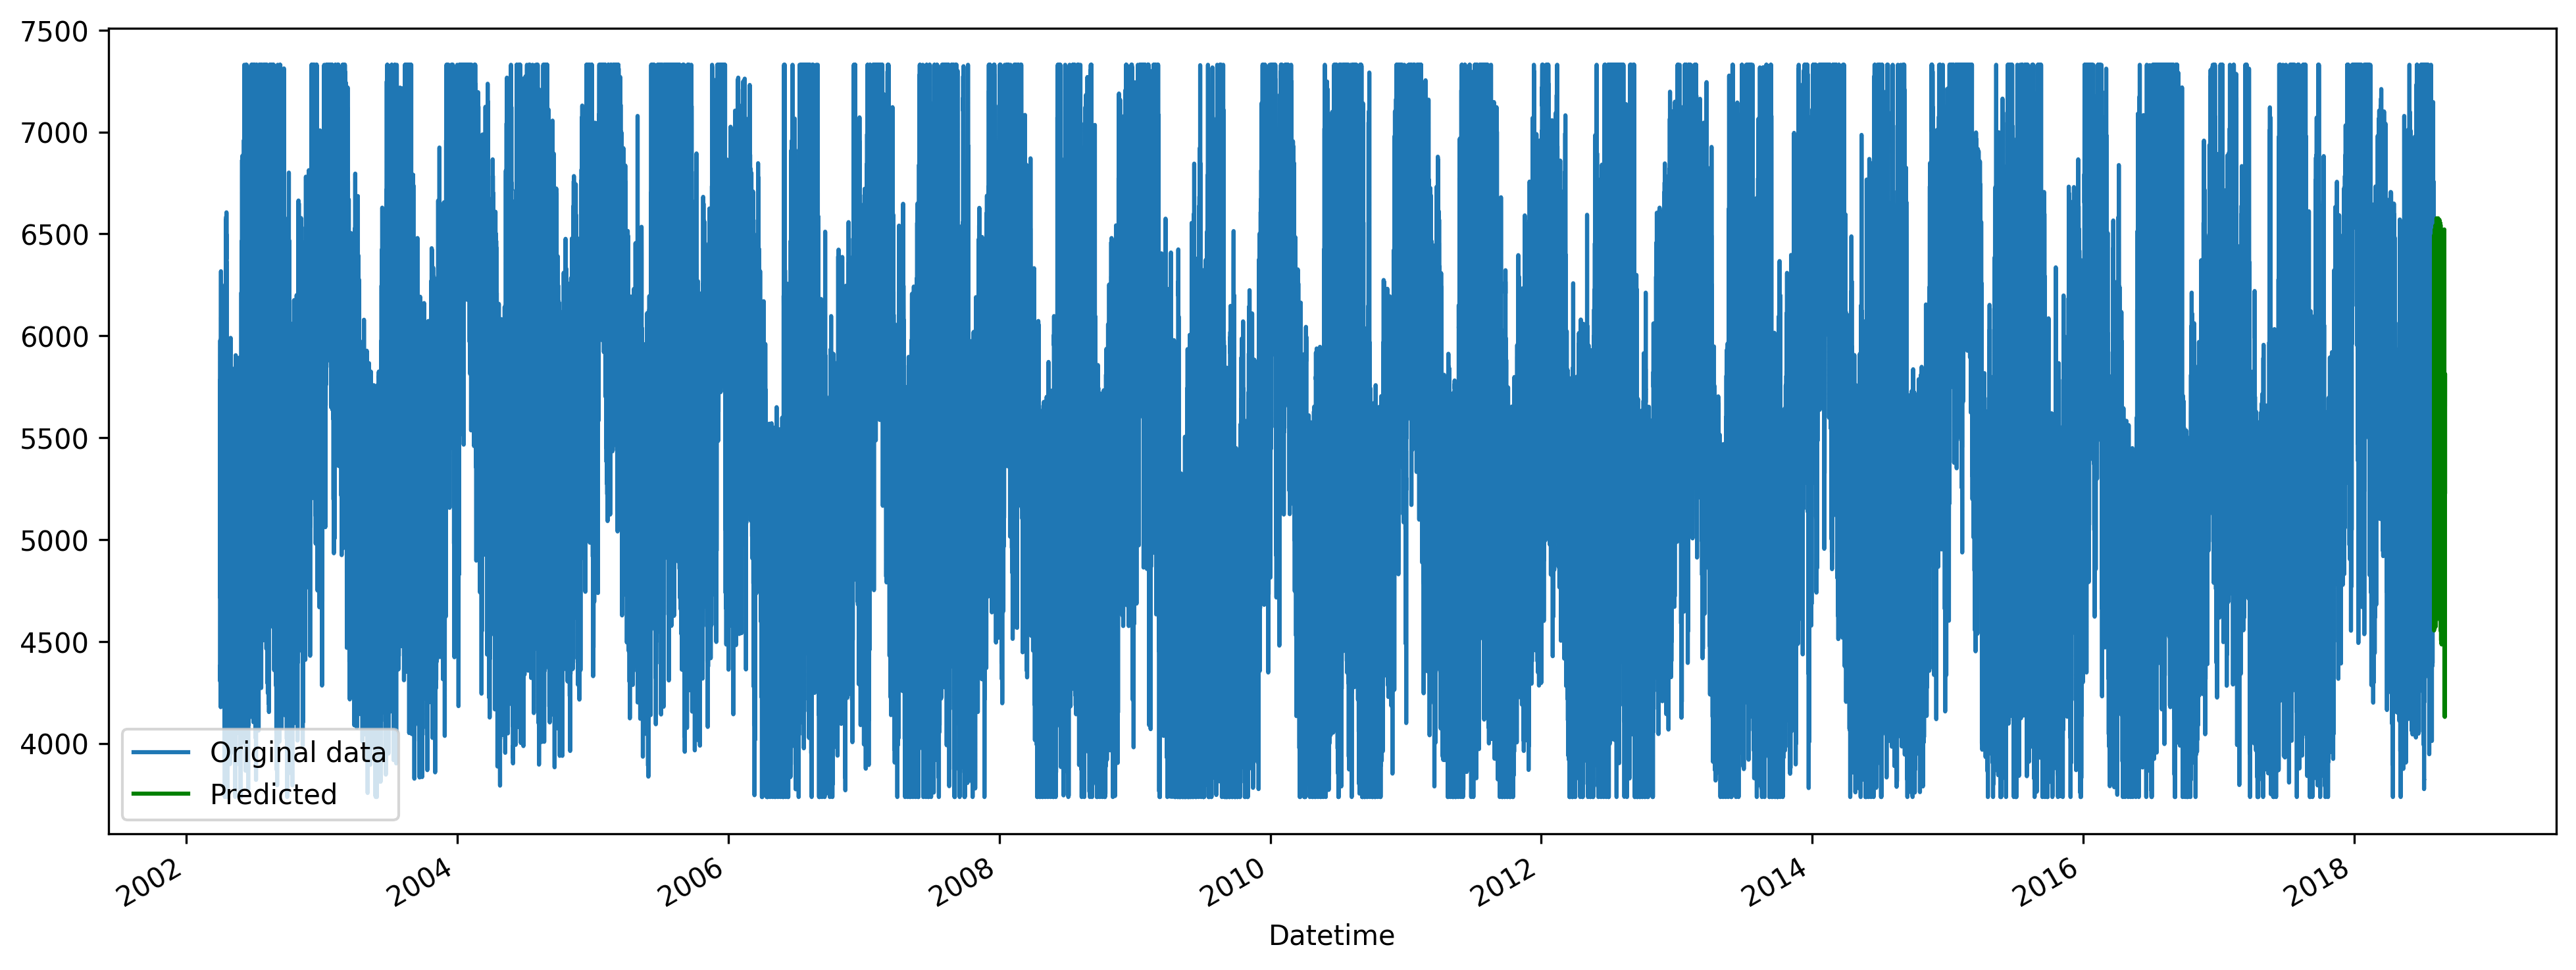

In [27]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize']=(16,8)
plt.rcParams['figure.dpi']= 300
df['PJMW_MW'].plot(ax=ax, label='Original data')
#final_pred.plot(ax=ax, label='Predicted')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Predicted', 'Forecast'])

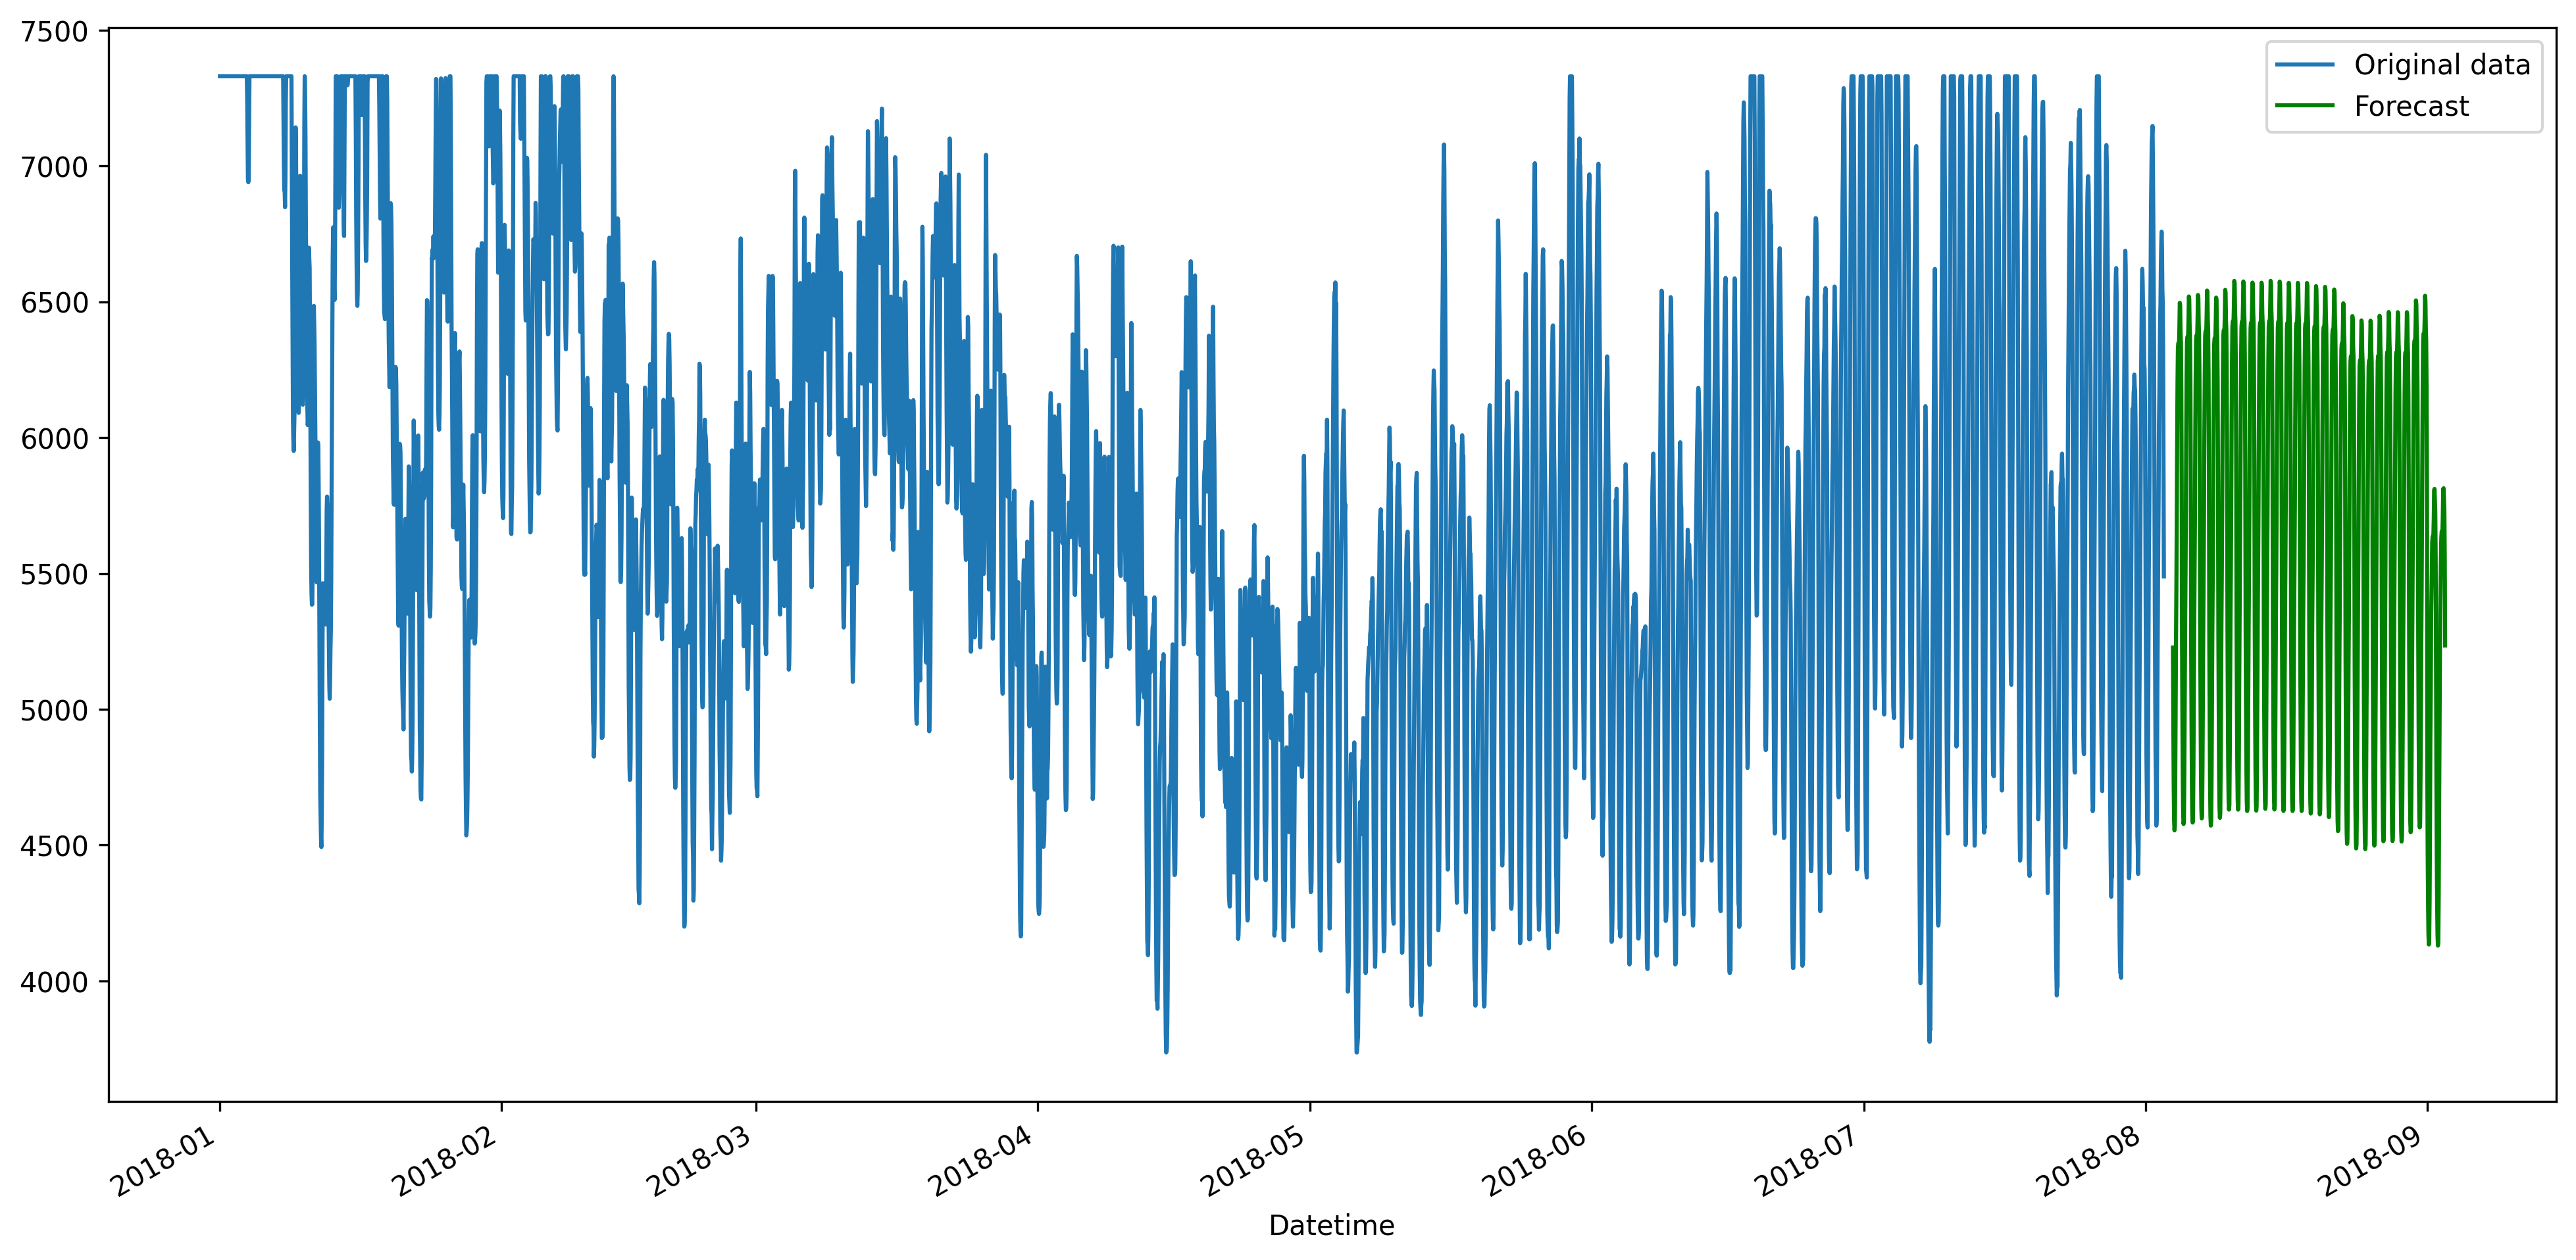

In [28]:
fig, ax = plt.subplots()
ytest['PJMW_MW'].plot(ax=ax, label='Original data')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Forecast'])

In [26]:
import pickle

pickle.dump(xg_model, open('xg_model_value.pkl', 'wb'))

In [27]:
xg_model.predict([[8,1,2018,4]])

array([6176.2607], dtype=float32)

In [28]:
model = open('xg_model_value.pkl','rb')
xg_model = pickle.load(model)

In [29]:
xg_model.predict([[8,1,2018,4]])

array([6176.2607], dtype=float32)